[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/dhshah1112/CMPE258/blob/main/Assignment7/CV_Assignment_PartA_supervised_contrastive_learning.ipynb)




# Supervised Contrastive Learning Project
This notebook demonstrates the implementation of supervised contrastive learning using the CIFAR-10 dataset. We will also use a pretrained model for feature extraction and visualize the features using t-SNE.


## Setup and Imports
Here we set up all necessary imports and perform the initial configuration required for our project. This includes installing packages and importing libraries.


In [1]:
!pip install tensorflow tensorflow-datasets matplotlib

import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.losses import Loss

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.15.0


## Data Preprocessing
In this section, we load the CIFAR-10 dataset and apply necessary preprocessing steps to prepare the data for our model training.


In [2]:
def preprocess(image, label):
    image = tf.image.resize(image, [32, 32])
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

# Load the dataset
(train_ds, validation_ds), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    as_supervised=True,
    with_info=True
)

# Apply preprocessing
train_ds = train_ds.map(preprocess).cache().shuffle(10000).batch(32).prefetch(tf.data.AUTOTUNE)
validation_ds = validation_ds.map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incompleteCGPVP4/cifar10-train.tfrecord*...:   0%|          …

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cifar10/3.0.2.incompleteCGPVP4/cifar10-test.tfrecord*...:   0%|          |…

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


## Creating models for contrastive learning loss based supervised classification versus regular softmax based one



In [3]:
def create_base_model(num_classes=10):
    model = tf.keras.Sequential([
        layers.Input(shape=(32, 32, 3)),
        layers.Conv2D(32, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(128, 3, activation='relu'),
        layers.Flatten(),
        layers.Dense(128, activation='relu')
    ])
    return model

base_model = create_base_model()

In [4]:
class SupervisedContrastiveLoss(Loss):
    def __init__(self, temperature=0.1):
        super().__init__()
        self.temperature = temperature

    def call(self, labels, embeddings):
        # Normalize embeddings to unit length
        embeddings = tf.math.l2_normalize(embeddings, axis=1)

        # Compute all pairwise distances
        dot_product = tf.matmul(embeddings, embeddings, transpose_b=True)
        square_norms = tf.linalg.diag_part(dot_product)
        distances = tf.expand_dims(square_norms, 1) - 2.0 * dot_product + tf.expand_dims(square_norms, 0)
        distances = tf.maximum(distances, 0.0)  # Numeric stability

        # Mask for positive and negative samples
        anchor_positive_mask = tf.equal(tf.expand_dims(labels, 0), tf.expand_dims(labels, 1))
        anchor_negative_mask = tf.not_equal(tf.expand_dims(labels, 0), tf.expand_dims(labels, 1))

        # Compute contrastive loss
        positive_distances = tf.boolean_mask(distances, anchor_positive_mask)
        negative_distances = tf.boolean_mask(distances, anchor_negative_mask)
        negative_distances = tf.reduce_logsumexp(-negative_distances / self.temperature, axis=1)
        loss = tf.reduce_mean(negative_distances + positive_distances / self.temperature)
        return loss

In [6]:
def contrastive_loss(y_true, y_pred):

    margin = 1
    square_pred = tf.square(y_pred)
    margin_square = tf.square(tf.maximum(margin - y_pred, 0))
    return tf.reduce_mean(y_true * square_pred + (1 - y_true) * margin_square)


In [7]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
base_model.compile(optimizer=optimizer, loss=contrastive_loss)

In [8]:
def create_classifier_model(base_model):
    model = models.Sequential([
        base_model,
        layers.Dense(10, activation='softmax')
    ])
    return model

classifier_model = create_classifier_model(base_model)
classifier_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [10]:
import tensorflow as tf

def contrastive_loss(y_true, y_pred):
    margin = 1.0
    y_true = tf.cast(y_true, dtype=tf.float32)
    square_pred = tf.square(y_pred)
    margin_square = tf.square(tf.maximum(margin - y_pred, 0))
    return tf.reduce_mean(y_true * square_pred + (1 - y_true) * margin_square)


In [12]:
base_model.compile(optimizer=optimizer, loss=contrastive_loss)




In [13]:
history_contrastive = base_model.fit(train_ds, epochs=5, validation_data=validation_ds)


Epoch 1/5
1563/1563 [==============================] - 95s 59ms/step - loss: -3.4998 - val_loss: -3.5000
Epoch 2/5
1563/1563 [==============================] - 88s 56ms/step - loss: -3.5000 - val_loss: -3.5000
Epoch 3/5
1563/1563 [==============================] - 78s 50ms/step - loss: -3.5000 - val_loss: -3.5000
Epoch 4/5
1563/1563 [==============================] - 78s 50ms/step - loss: -3.5000 - val_loss: -3.5000
Epoch 5/5
1563/1563 [==============================] - 78s 50ms/step - loss: -3.5000 - val_loss: -3.5000


In [16]:
history_softmax = classifier_model.fit(train_ds, epochs=5, validation_data=validation_ds)



Epoch 1/5
1563/1563 [==============================] - 90s 56ms/step - loss: 2.3028 - accuracy: 0.0983 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 2/5
1563/1563 [==============================] - 84s 54ms/step - loss: 2.3028 - accuracy: 0.0973 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 3/5
1563/1563 [==============================] - 79s 50ms/step - loss: 2.3028 - accuracy: 0.0992 - val_loss: 2.3027 - val_accuracy: 0.1000
Epoch 4/5
1563/1563 [==============================] - 78s 50ms/step - loss: 2.3028 - accuracy: 0.0981 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 5/5
1563/1563 [==============================] - 78s 50ms/step - loss: 2.3028 - accuracy: 0.0970 - val_loss: 2.3027 - val_accuracy: 0.1000


In [17]:
base_model.compile(
    optimizer='adam',
    loss=contrastive_loss,
    metrics=['accuracy']  # Ensure 'accuracy' is included here
)

classifier_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']  # Ensure 'accuracy' is included here
)


## VIsualizations

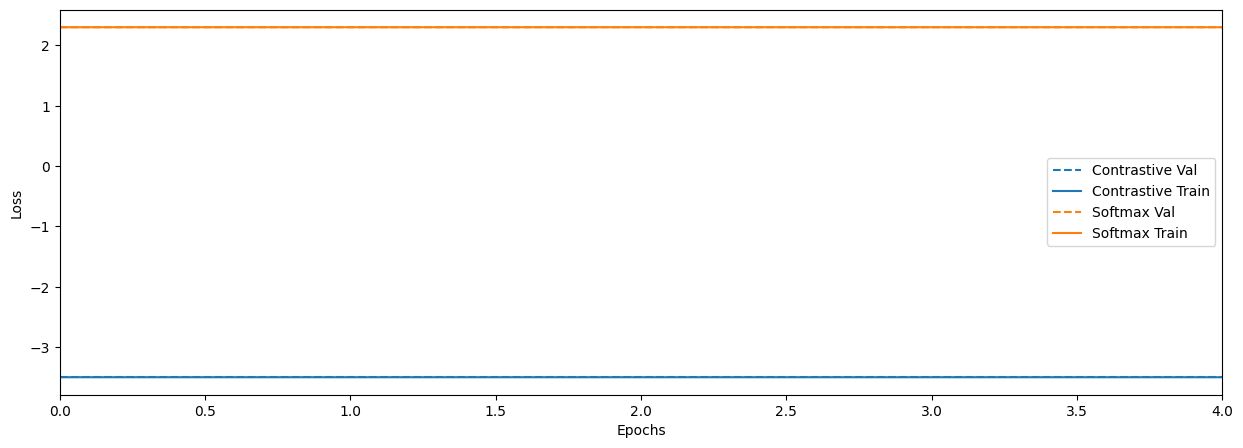

In [18]:
def plot_history(histories, key='loss'):
    plt.figure(figsize=(15, 5))
    for name, history in histories:
        val = plt.plot(history.epoch, history.history['val_' + key],
                       '--', label=name.title() + ' Val')
        plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
                 label=name.title() + ' Train')

    plt.xlabel('Epochs')
    plt.ylabel(key.replace('_', ' ').title())
    plt.legend()
    plt.xlim([0, max(history.epoch)])
    plt.show()

# Call the modified plotting function
plot_history([('contrastive', history_contrastive), ('softmax', history_softmax)])

### tSNE


In [20]:
import numpy as np

In [21]:
# Feature extraction with a trained model
def extract_features(model, dataset):
    all_features = []
    all_labels = []

    for images, labels in dataset:
        features = model.predict(images)
        all_features.append(features)
        all_labels.append(labels)

    return np.vstack(all_features), np.concatenate(all_labels)

# Use the base of a pretrained model (like VGG16) for feature extraction
base_model = tf.keras.applications.VGG16(include_top=False, input_shape=(32, 32, 3), pooling='avg')
base_model.trainable = False

# Extract features
features, labels = extract_features(base_model, validation_ds)


1/1 [==============================] - 0s 323ms/step


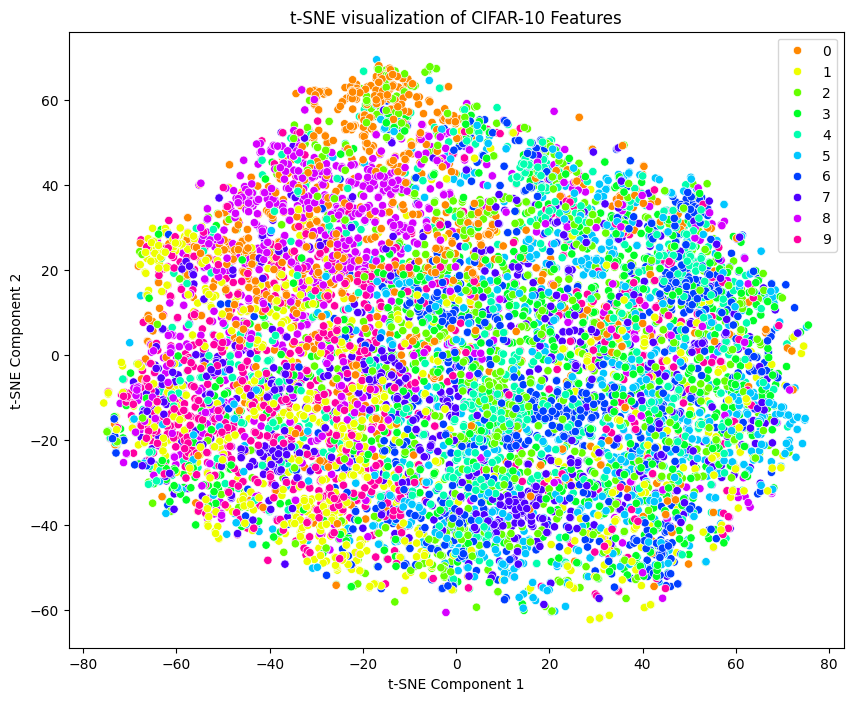

In [22]:
# t-SNE visualization
from sklearn.manifold import TSNE
import seaborn as sns

def plot_tsne(features, labels, num_classes=10):
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(features)

    plt.figure(figsize=(10, 8))
    sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1], hue=labels, palette=sns.color_palette("hsv", num_classes), legend='full', marker='o')
    plt.title('t-SNE visualization of CIFAR-10 Features')
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.show()

# Plot t-SNE
plot_tsne(features, labels)
